Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


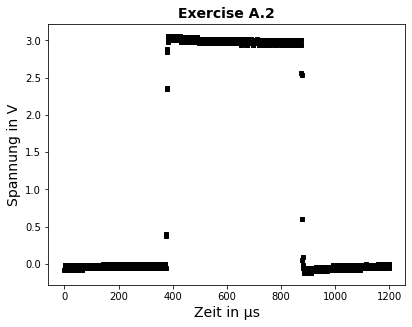

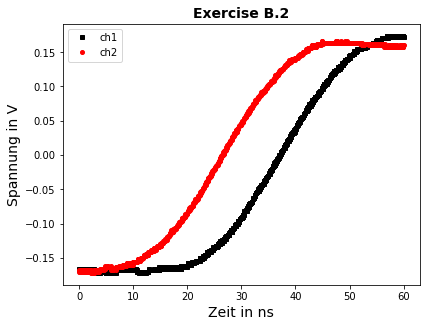

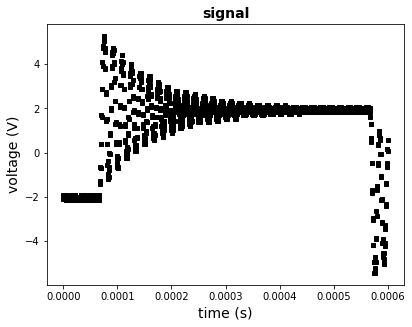

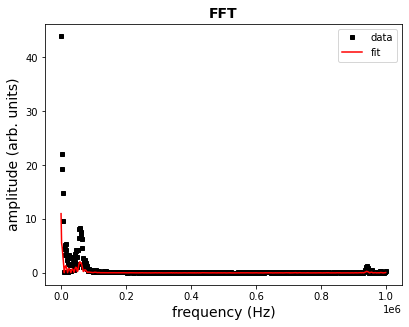

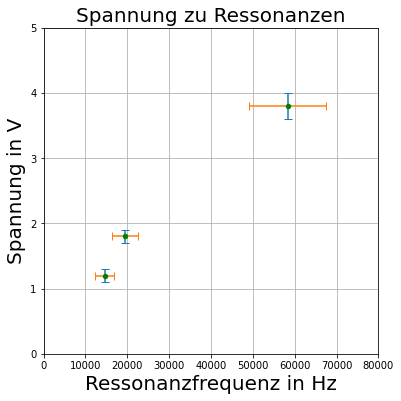

Hoffmann, Robin (n:12104380) -> ?
Rauschegger, Quirin (n:01611893) -> ?


In [4]:
from scipy.linalg import cho_factor

# -----------------------------------------------
# data analysis for experiment 'GPI - Oscilloscope'.
# ----------------------------------------------
# Output your numeric results the SI units: m, m/s, Hz, s, V.
# Tip: use abbreviated units such as ns or kHz to keep numbers
# around the value of 1 because the numerical analysis is more reliable.
#----------------------------------------------
# The program should execute the entire data analysis from the raw data.
# !!! Make sure the analysis executes without problems before submission.
#
# Tip: Execute the original script to understand the format of the
# output file. The script can then be gradually modified to perform
# a meaningful data analysis. Make incremental modifications and test often.
#----------------------------------------------
# RECOMMENDED BUT NOT COMPULSORY

# Please consider the following recommendation from the "GNU Coding
# Standards" paragraph 5.2 regarding "Commenting Your Work"

#"Please write the comments in a GNU program in English, because English
# is the one language that nearly all programmers in all countries can read.
# If you do not write English well, please write comments in English as
# well as you can, then ask other people to help rewrite them.
# If you can’t write comments in English, please find someone to work with
# you and translate your comments into English."

# source: https://www.gnu.org/prep/standards/html_node/Comments.html
# (accessed on 01/12/2022 at 11:31)

!pip install uncertainties
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy as unp

def single_input_read_oscilloscope_csv_data(filename):
  # This function can be used to read the data saved from the oscilloscope.
  # It might be necessary to adapt it to the actual file format that the used
  # oscilloscope outputs.
  # function's inputs
  # - filename -> the name of the file containing the data
  # function's outputs
  # - t -> vector containing the sampling time points
  # - ch1 -> vector containing the voltage values measured on CH1
  # - ch2 -> vector containing the voltage values measured on CH2
  fid = open(filename,'r')
  lines = fid.readlines()
  fid.close()
  line2 = lines[1].split(',')
  
  t_start = np.float64(line2[2])
  t_step = np.float64(line2[3])
  
  t = np.linspace(0,0,len(lines)-2)
  ch1 = t.copy()
  for n in range(2,len(lines)):
    line = lines[n].split(',')
    t[n-2] = np.float64(line[0])*t_step+t_start
    ch1[n-2] = np.float64(line[1])
  return t,ch1

def read_oscilloscope_csv_data(filename):
  # This function can be used to read the data saved from the oscilloscope.
  # It might be necessary to adapt it to the actual file format that the used
  # oscilloscope outputs.
  # function's inputs
  # - filename -> the name of the file containing the data
  # function's outputs
  # - t -> vector containing the sampling time points
  # - ch1 -> vector containing the voltage values measured on CH1
  # - ch2 -> vector containing the voltage values measured on CH2
  fid = open(filename,'r')
  lines = fid.readlines()
  fid.close()
  line2 = lines[1].split(',')
  
  t_start = np.float64(line2[3])
  t_step = np.float64(line2[4])
  
  t = np.linspace(0,0,len(lines)-2)
  ch1 = t.copy()
  ch2 = t.copy()
  for n in range(2,len(lines)):
    line = lines[n].split(',')
    t[n-2] = np.float64(line[0])*t_step+t_start
    ch1[n-2] = np.float64(line[1])
    ch2[n-2] = np.float64(line[2])
  return t,ch1,ch2

def resizeplot_addlabels_save(title_label,x_label,y_label,filename,fig,ax):
  # This function make a nice looking plot and adds the labels
  # function's inputs
  # - title_label -> title of the plot
  # - x_label -> label for the x axis
  # - y_label -> label for the y axis
  # - filename -> name of the output file
  # function's outputs
  # none
  #---
  # reset appearance of figure
  my_dpi = 100
  fig.set_size_inches(640/my_dpi, 480/my_dpi)
  
  # setting font size. This function resets the font size of the entire plot
  # set(gca,'FontSize',15,'LineWidth',1);
  ax.set_xlabel(x_label,fontsize=14)
  ax.set_ylabel(y_label,fontsize=14)
  ax.set_title(title_label,fontsize=14, fontweight = 'bold')
  plt.draw()
  fig.savefig(filename, dpi=my_dpi)
  return

def plot_one_trace(x,y,figure_number, title_label,x_label,y_label, filename_out):
  # This function can be used to plot experimental data
  # function's inputs
  # - x -> values on the x axis
  # - y -> values on the y axis
  # - figure_number -> id of the figure
  # - title_label,x_label,y_label, filename_out -> see
  #                        resizeplot_addlabels_save()
  # function's outputs
  # none
  fig, ax = plt.subplots()
  ax.plot(x,y,'sk', markersize= 4, markerfacecolor = 'k')
  resizeplot_addlabels_save(title_label,x_label,y_label,filename_out, fig, ax);
  return

def plot_two_traces(x1,y1, x2,y2, figure_number, \
    title_label, x_label, y_label, filename_out):
  # This function can be used to plot experimental data
  # function's inputs
  # - x1 -> values on the x axis corresponding to y1
  # - y1 -> values on the y axis corresponding to x1
  # - x2 -> values on the x axis corresponding to y2
  # - y2 -> values on the y axis corresponding to x2
  # - figure_number -> id of the figure
  # - title_label,x_label,y_label, filename_out -> see
  #                        resizeplot_addlabels_save()
  # function's outputs
  # none
  fig, ax = plt.subplots()
  ax.plot(x1,y1,'sk', markersize= 4, markerfacecolor = 'k' , label='ch1')
  ax.plot(x2,y2,'or', markersize= 4, markerfacecolor = 'r' , label='ch2')
  ax.legend()
  resizeplot_addlabels_save(title_label,x_label,y_label,filename_out, fig, ax)
  return

def plot_one_trace_and_one_fitline(x,y, xfit,yfit, figure_number, \
    title_label,x_label,y_label, filename_out):
  # This function can be used to plot experimental data
  # function's inputs
  # - x1 -> values on the x axis corresponding to y1
  # - y1 -> values on the y axis corresponding to x1
  # - x2 -> values on the x axis corresponding to y2
  # - y2 -> values on the y axis corresponding to x2
  # - figure_number -> id of the figure
  # - title_label,x_label,y_label, filename_out -> see
  #                        resizeplot_addlabels_save()
  # function's outputs
  # none
  fig, ax = plt.subplots()
  ax.plot(x,y,'sk', markersize= 4, markerfacecolor =  'k', label='data')
  ax.plot(xfit,yfit,'r-', label='fit')
  ax.legend()
  resizeplot_addlabels_save(title_label,x_label,y_label,filename_out, fig, ax);
  return


def linfunc(x,a,b):
  return a * x + b

def exercise_example():
  # DO NOT MODIFY THE EXAMPLE
  # This function provides an example of how to analyze the data
  # It will estimate,
  # - EX.1 the maximum of the voltage signal on ch1 vmax
  # - EX.2 the minimum of the voltage signal on ch1 vmin
  # - EX.3 the time the signal crosses the voltage (vmax-vmin)/2
  #
  # function's inputs
  # none
  # function's outputs
  # t -> vector of time points
  # ch1 -> vector of voltage values recorded at ch1
  # ch2 -> vector of voltages values recorded at ch2

  # --------------------------------
  # raw data files and, if necessary, other relevant experimental parameters
  filename_data = './SignalSpeed_NotTerminated.csv'
  #---------------------------------
  # load data
  [t_raw, ch1_raw, ch2_raw] = read_oscilloscope_csv_data(filename_data)
  #---------------------------------
  # data analysis

  # converting time to ns
  t = t_raw*1e9 # s -> ns
  ch1 = ch1_raw # V-> V
  ch2 = ch2_raw # V-> V
  # show data
  plot_two_traces(t,ch1, t, ch2, 1, 'test','time (ns)','voltage (V)', 'test.pdf')
  #-------------
  # EX.1 - vmax
  # time at which the signal has reached vmax
  t_max = 40 #ns
  # find where t is larger than t_max
  ind_max = np.where(t>t_max)
  # average and standard deviation of the signal on ch1 for t>t_max
  vmax = np.mean(ch1[ind_max])
  vmax_uncertainty = np.std(ch1[ind_max])
  #-------------
  # EX.2 - vmin
  # time at which the signal is still at vmin
  t_min = -1 #ns
  # find where t is smaller than t_min
  ind_min = np.where(t<t_min)
  # average and standard deviation of the signal on ch1 for t<t_min
  vmin = np.mean(ch1[ind_min])
  vmin_uncertainty = np.std(ch1[ind_min])
  #-------------
  # EX.2 - time at which the signal crosses (vmax-vmin)/2
  # selection of the fit range
  t_range = [0, 15] #ns
  ind_range = np.where((t>t_range[0]) & (t<t_range[1]))
  t_fit = t[ind_range]
  v_fit = ch1[ind_range]
  # fitting a straight line to the data in the selected region
  # using equation t = a*v+b -> t = coeff(1)*v+coeff(2)
  popt, pcov = curve_fit(linfunc, v_fit, t_fit)
  # extracting coefficient values
  coeff = popt
  # uncertainty is defined here as the coefficient bound at 68# confidence level
  sigma_coeff = 0*coeff
  sigma_coeff[0] = np.sqrt(pcov[0,0])
  sigma_coeff[1] = np.sqrt(pcov[1,1])
  # crossing voltage
  v_cross = (vmax-vmin)/2;
  v_cross_uncertainty = np.sqrt(np.power(vmax_uncertainty,2) + np.power(vmin_uncertainty,2))
  # crossing time evaluated from t = coeff(1)*v+coeff(2)
  t_cross = coeff[0] * v_cross + coeff[1]
  t_cross_uncertainty = np.sqrt( np.power(sigma_coeff[1],2) + \
      np.power(coeff[0] * v_cross_uncertainty,2) + np.power(sigma_coeff[0] * v_cross,2))
  #---------------------------------
  # output
  vmax_unit = 'V'
  vmin_unit = 'V'
  t_cross_unit = 'ns'
  x_label = 'time (ns)'
  y_label = 'voltage (V)'
  # line for the plot
  t_fit_plot = coeff[0]*v_fit+coeff[1];
  plot_one_trace_and_one_fitline(t, ch1, t_fit_plot,v_fit, \
      100,'example',x_label, y_label, 'exercise_example_plot.pdf')
  # Writing output to file
  fid = open('exercise_example_results.txt','w')
  fid.write('vmax = %f %s\n'% (vmax, vmax_unit))
  fid.write('vmax_uncertainty = %f %s\n'% (vmax_uncertainty, vmax_unit))
  fid.write('vmin = %f %s\n'% (vmin, vmin_unit))
  fid.write('vmin_uncertainty = %f %s\n'% (vmin_uncertainty, vmin_unit))
  fid.write('t_crossing = %f %s\n'% (t_cross, t_cross_unit))
  fid.write('t_crossing_uncertainty = %f %s\n'% (t_cross_uncertainty, t_cross_unit))
  fid.close()

  return t_raw, ch1_raw, ch2_raw


def exercise_A():
  # This function should be modified for the analysis of exercise A.
  # function's inputs
  # None
  # function's outputs
  # t_raw -> vector of times (will be used for the evaluation)
  # ch1_raw -> vector of voltage values recorded at ch1 (will be used for the evaluation)
  # ch2_raw -> vector of voltage values recorded at ch2 (will be used for the evaluation)
  #------------------------------------------
  #------------------------------------------

  # --------------------------------
  # raw data files and, if necessary, other relevant experimental parameters
  filename_data = './A.csv'  
  #---------------------------------
  # load data
  [t_raw, ch1_raw] = single_input_read_oscilloscope_csv_data(filename_data)
  # variables to be modified for the analysis
  #---------------------------------
  # data analysis
  # converting time to ns
  t_raw = np.linspace(0,1200,1200);
  increment = 1.000000e-06
  t = t_raw*increment*1e6 # s -> µs
  ch1 = ch1_raw # V-> V
  # variables to be calculated in the analysis
  array_ch1 = np.array([])
  for i in range(ch1.argmax(), ch1.argmin()-20):
    array_ch1 = np.append(array_ch1, ch1[i])

  T = ufloat((ch1.argmin() - ch1.argmax())*increment*2, increment*2)
  
  amplitude = ufloat(np.mean(array_ch1),np.std(array_ch1)); #V
  amplitude_unit = 'V';
  frequency = 1/T; # Hz
  frequency_unit = 'Hz';
  #print('Amplitude=', amplitude, amplitude_unit)
  #print('Frequency=', frequency, frequency_unit)

  #----------------------

  #------------------------------------------
  #------------------------------------------
  # output

  # titles and lables for the plot. Modify as necessary.
  x_label = 'Zeit in µs';
  y_label = 'Spannung in V';

  # +++++++++++++++++++++++++++++++++++++++++++++
  # Writing output to file
  # WARNING: do not modify the lines inside "+" lines because they will
  # be used in the evaluation process. They must work properly.
  fid = open('exercise_A_results.txt','w')
  fid.write('amplitude = %f %s\n' % (amplitude.nominal_value, amplitude_unit))
  fid.write('amplitude_uncertainty = %f %s\n' % (amplitude.std_dev, amplitude_unit))
  fid.write('frequency = %f %s\n' % (frequency.nominal_value, frequency_unit))
  fid.write('frequency_uncertainty = %f %s\n' % (frequency.std_dev, frequency_unit))
  fid.close()
  plot_one_trace(t, ch1, 101, 'Exercise A.2', x_label, y_label, 'exerciseA2_plot.pdf')
  # +++++++++++++++++++++++++++++++++++++++++++++
  # overwrite here the file './exerciseA2_plot.pdf' if needed

  return t_raw, ch1_raw

def exercise_B():
  # This function should be modified for the analysis of exercise B.
  # function's inputs
  # None
  # function's outputs
  # t_raw -> vector of times (will be used for the evaluation)
  # ch1_raw -> vector of voltage values recorded at ch1 (will be used for the evaluation)
  # ch2_raw -> vector of voltage values recorded at ch2 (will be used for the evaluation)
  # --------------------------------
  # raw data files and, if necessary, other relevant experimental parameters
  length_cable_ch1 = ufloat(2.98,0.01); # m
  length_cable_ch2 = ufloat(1.02,0.01); # m
  length_cable_unit = 'm';
  filename_data = './B.csv'
  [t_raw, ch1_raw, ch2_raw] = read_oscilloscope_csv_data(filename_data)
  

  # variables to be modified for the analysis
  t_raw = np.linspace(0,1200,1200);
  increment = 5.000000e-11
  t = t_raw*increment*1e9 # s -> ns 
  ch1 = ch1_raw;
  ch2 = ch2_raw;
  # variables to be calculated in the analysis
  # time distance between the two channels and uncertainty of the
  # measurement

  array_delta_t = np.array([])
  for i in range(200, 800):
    for j in range(400, 1000):
      if ch2[i] == ch1[j]:
        array_delta_t = np.append(array_delta_t, t[j]-t[i])

  delta_t = ufloat(np.mean(array_delta_t),np.std(array_delta_t)) ; #s
  signal_speed = (length_cable_ch1 - length_cable_ch2)/delta_t ; #m/ns

  #------------------------------------------
  #------------------------------------------
  # output
  # titles, labels and units for the output. Modify as necessary.
  x_label = 'Zeit in ns';
  y_label = 'Spannung in V';
  delta_t_unit = 'ns';
  speed_unit = 'm/ns';

  #print('delta_t=', delta_t, delta_t_unit)
  #print('signal_speed=', signal_speed, speed_unit)

  # +++++++++++++++++++++++++++++++++++++++++++++
  # Writing output to file
  # WARNING: do not modify the lines inside "+" lines because they will
  # be used in the evaluation process. They must work properly.
  fid = open('exercise_B_results.txt','w')
  fid.write('lenght_cable_ch1 = %f %s\n' % (length_cable_ch1.nominal_value, length_cable_unit))
  fid.write('lenght_cable_ch1_uncertainty = %f %s\n'% ( length_cable_ch1.std_dev, length_cable_unit))
  fid.write('lenght_cable_ch2 = %f %s\n'% ( length_cable_ch2.nominal_value, length_cable_unit))
  fid.write('lenght_cable_ch2_uncertainty = %f %s\n'% ( length_cable_ch2.std_dev, length_cable_unit))
  fid.write('time_separation = %f %s\n'% ( delta_t.nominal_value, delta_t_unit))
  fid.write('time_separation_uncertainty = %f %s\n'% ( delta_t.std_dev, delta_t_unit))
  fid.write('signal_speed = %f %s\n'% ( signal_speed.nominal_value, speed_unit))
  fid.write('signal_speed_uncertainty = %f %s\n'% ( signal_speed.std_dev, speed_unit))
  fid.close()
  plot_two_traces(t, ch1, t, ch2, 102, 'Exercise B.2', x_label, y_label, 'exerciseB2_plot.pdf')
  # +++++++++++++++++++++++++++++++++++++++++++++
  # overwrite here the file './exerciseB2_plot.pdf' if needed
  return t_raw, ch1_raw, ch2_raw

def exercise_C():
  # function's inputs
  # None
  # function's outputs
  # t_raw -> vector of times (will be used for the evaluation)
  # ch1_raw -> vector of voltage values recorded at ch1 (will be used for the evaluation)
  # ch2_raw -> vector of voltage values recorded at ch2 (will be used for the evaluation)

  # --------------------------------
  # raw data files and, if necessary, other relevant experimental parameters

  filename_data = './C.csv'
  [t_raw, ch1_raw, ch2_raw] = read_oscilloscope_csv_data(filename_data)
  # variables to be modified for the analysis
  t_raw = np.linspace(0,1200,1200);
  increment = 5.000000e-07
  t = t_raw.copy()*increment
  #ch1_raw = np.multiply(np.sin(2*np.pi*1*t),np.exp(-t/10))
  ch1 = ch1_raw.copy()
  ch2_raw = ch1.copy()
  ch2 = ch1.copy()
  #----------------------------------------------
  # Code tip: normalized FFT and frequency range. Usage highly reccomended.
  dim = t.shape[0]
  f = np.linspace(0,dim-1, dim) 
  f = f/(np.max(t)-np.min(t))
  ch1f = np.fft.fft(ch1)/np.sqrt(dim)
  ch1f = np.abs(ch1f)
  ind = np.int32(np.linspace(0, np.int32(np.round(dim/2)-1), np.int32(np.round(dim/2))))
  f = f[ind]
  ch1f = ch1f[ind]
  #----------------------------------------------
  #plot_one_trace(f,ch1f, 2,'FFT','frequency (Hz)','amplitude (arb. units)', 'test.pdf')

  # variables to be calculated in the analysis
  new_ch1f = np.array([])
  for i in range(10,len(ind)-1,1):
    new_ch1f = np.append(new_ch1f, ch1f[i])
  f_res_max = (new_ch1f.argmax()+10)*1e6/len(ind)
  x=0
  for i in range(0,len(ind)-11,1):
    if new_ch1f[i] > 4:
     x=x+1
  f_res_uncertainty = x/2 *1e6/len(ind)

  # resonance frequency
  f_res = ufloat(f_res_max, f_res_uncertainty) #Hz
  f_res_unit = 'kHz'
  f_res2 = f_res/3
  f_res3 = f_res/4
  V_res = ufloat(3.8, 0.2)
  V_res2 = ufloat(1.8,0.1)
  V_res3 = ufloat(1.2, 0.1)

  array_V_res = np.array([V_res.nominal_value, V_res2.nominal_value, V_res3.nominal_value])
  array_V_res_error = np.array([V_res.std_dev, V_res2.std_dev, V_res3.std_dev])
  array_f_res = np.array([f_res.nominal_value, f_res2.nominal_value, f_res3.nominal_value])
  array_f_res_error = np.array([f_res.std_dev, f_res2.std_dev, f_res3.std_dev])

  #print(array_V_res)
  #print(array_V_res_error)
  #print(array_f_res)
  #print(array_f_res_error)


  #print('f_res=', f_res, f_res_unit)
  #print('f_res2=', f_res2, f_res_unit)
  #print('f_res3=', f_res3, f_res_unit)

  #------------------------------------------
  #------------------------------------------
  # output
  # titles, lables and units for the output. Modify as necessary.
  x_label = '';
  y_label = '';
  delta_t_unit = 'ns';
  speed_unit = 'm/ns';

  # +++++++++++++++++++++++++++++++++++++++++++++
  # Writing output to file
  # WARNING: do not modify the lines inside "+" lines because they will
  # be used in the evaluation process. They must work properly.
  fid = open('exercise_C_results.txt','w')
  fid.write('res_frequency = %f %s\n'% ( f_res.nominal_value, f_res_unit))
  fid.write('res_frequency_uncertainty = %f %s\n'% ( f_res.std_dev, f_res_unit))
  fid.write('res_frequency2 = %f %s\n'% ( f_res2.nominal_value, f_res_unit))
  fid.write('res_frequency2_uncertainty = %f %s\n'% ( f_res2.std_dev, f_res_unit))
  fid.write('res_frequency3 = %f %s\n'% ( f_res3.nominal_value, f_res_unit))
  fid.write('res_frequency3_uncertainty = %f %s\n'% ( f_res3.std_dev, f_res_unit))
  fid.write('Bei Freuqenzen welche ein Teiler der Ressonanzfrequenz sind kommt es zu Teilressonanz, da die Impulsanregung durch die quadratische Welle weiterhin in Phase ist.')
  fid.close()
  # +++++++++++++++++++++++++++++++++++++++++++++
  # prepare appropriate output figures and save them to file. The name of the
  # files should be 'exercise_C<NUMBER>_plot.pdf' as in the previous exercises.
  # examples:
  plot_one_trace(t,ch1,104, 'signal','time (s)','voltage (V)', 'exerciseC2_plot.pdf')
  plot_one_trace_and_one_fitline(f,ch1f,f,ch1f/4,105,'FFT', \
      'frequency (Hz)','amplitude (arb. units)', 'exerciseC3_plot.pdf')

  fig, axs = plt.subplots(1,1,figsize=(6, 6));
  plt.scatter(array_f_res, array_V_res, label = 'Daten', color='green', s=20, zorder= 5)
  axs.errorbar(array_f_res,array_V_res,yerr = array_V_res_error,linestyle='none',capsize = 4, label = r'$δV$');
  axs.errorbar(array_f_res,array_V_res,xerr = array_f_res_error,linestyle='none',capsize = 4, label = r'$δt$');

  axs.set_xlabel('Ressonanzfrequenz in Hz', fontsize = 20);
  axs.set_ylabel('Spannung in V', fontsize = 20);

  plt.axis([0, 80000, 0, 5]) #Achsenanpassung
  plt.title('Spannung zu Ressonanzen', fontsize = 20)
  plt.grid()
  plt.show()

  my_dpi = 100
  fig.savefig('exerciseC5_plot.pdf', dpi=my_dpi)

  return t_raw, ch1_raw, ch2_raw




def data_analysis_check(t_A, ch1_A, ch2_A, t_B, ch1_B, ch2_B, t_C, ch1_C, ch2_C):
  note = '?'
  return note


if __name__ == "__main__":
 

  #---------------------------------------------
  # Personal data
  # MODIFY HERE
  name = 'Hoffmann, Robin';
  name2 = 'Rauschegger, Quirin';

  # MODIFY HERE
  immatriculation_number = '12104380';
  immatriculation_number2 = '01611893';
  # MODIFY HERE
  date = '';
  #---------------------------------------------

  #----------------------------------------------
  # Do not modify code here, modify the code inside the indicated functions
  #[t_ex, ch1_ex, ch2_ex] = exercise_example();
  # modify this function
  [t_A, ch1_A] = exercise_A();
  # modify this function
  [t_B, ch1_B, ch2_B] = exercise_B();
  # modify this function
  [t_C, ch1_C, ch2_C] = exercise_C();
  #-------
  # Do not modify code here
  # This function will be called to benchmark the data analysis against 
  # the approach of the instructors. The function will re-analyze the data
  # open the output files and compare the obtained results of the two
  # analysis. Make sure that the variables t_A, ch1_A, ch2_A, t_B, ch1_B,
  # ch2_B, t_C, ch1_C, and ch2_C contains the correct data and that
  # all the output files of exercise_A(), exercise_B() and exercise_C() exist.
#  note = data_analysis_check(t_A, ch1_A, ch2_A, t_B, ch1_B, ch2_B, t_C, ch1_C, ch2_C);
  note = '?'
  print('%s (n:%s) -> %s' % (name, immatriculation_number, note))
  print('%s (n:%s) -> %s' % (name2, immatriculation_number2, note))
